In [4]:
import pandas as pd
import yfinance as yf

from pypfopt import expected_returns, risk_models, black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

import warnings
warnings.filterwarnings("ignore")

The Theoretical Foundation:
Market Equilibrium as a Starting Point
The model begins with a crucial assumption: the market portfolio represents an equilibrium state. This equilibrium serves as a neutral starting point, derived from the Capital Asset Pricing Model (CAPM). The mathematical representation of the expected return in the Black-Litterman model is:

E(R) = [(τΣ)^(-1) + P^T Ω^(-1)P]^(-1) × [(τΣ)^(-1)Π + P^T Ω^(-1)Q]

Where:

τ represents uncertainty in CAPM distribution

Σ is the covariance matrix of returns

P represents the matrix of investor views

Ω is the confidence in views

Π represents implied equilibrium returns

Q represents expected returns from views

In [5]:
mag_7 = [
    "AAPL",
    "AMZN",
    "NVDA",
    "TLSA",
    "GOOGL",
    "META",
    "MSFT",
]

prices = yf.download(mag_7, start="2018-01-01")["Adj Close"]

[*********************100%%**********************]  7 of 7 completed


In [6]:
views = {
    "AAPL": 0.10, 
    "AMZN": 0.20,  
    "NVDA": 0.30,  
    "TLSA": 0.50, 
    "GOOGL": -0.10,  
    "META": 0.10,  
    "MSFT": 0.15   
}

mcaps = {
    "AAPL": 2.5e12,
    "AMZN": 1.3e12,
    "NVDA": 1.0e12,
    "TLSA": 0.9e12,
    "GOOGL": 1.4e12,
    "META": 0.7e12,
    "MSFT": 2.0e12,
}

In [7]:
expected_returns_mean = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)
delta = black_litterman.market_implied_risk_aversion(prices)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

In [8]:
bl = BlackLittermanModel(
    cov_matrix,
    absolute_views=views,
    pi=market_prior
)

bl_returns = bl.bl_returns()
ef = EfficientFrontier(bl_returns, cov_matrix)
weights = ef.max_sharpe()

bl_weights = pd.DataFrame(
    list(weights.items()), 
    columns=["symbol", "weight"]
).set_index("symbol")

performance = ef.portfolio_performance(verbose=True)

Expected annual return: 16.9%
Annual volatility: 27.8%
Sharpe Ratio: 0.61


In [9]:
bl = BlackLittermanModel(
    cov_matrix,
    absolute_views=views,
    pi=market_prior
)

bl_returns = bl.bl_returns()
ef = EfficientFrontier(bl_returns, cov_matrix)
weights = ef.max_sharpe()

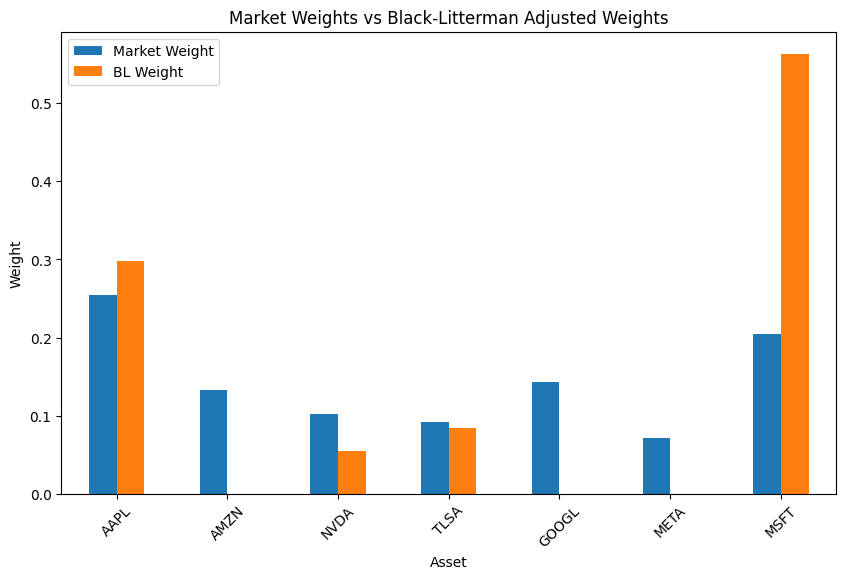

In [10]:
import matplotlib.pyplot as plt

market_weights = {symbol: mcaps[symbol] / sum(mcaps.values()) for symbol in mcaps}
market_weights_df = pd.DataFrame.from_dict(market_weights, orient='index', columns=['Market Weight'])
bl_weights_df = bl_weights.rename(columns={'weight': 'BL Weight'})

weights_df = market_weights_df.join(bl_weights_df)
weights_df.plot(kind='bar', figsize=(10, 6))

plt.title('Market Weights vs Black-Litterman Adjusted Weights')
plt.ylabel('Weight')
plt.xlabel('Asset')
plt.xticks(rotation=45)
plt.show()

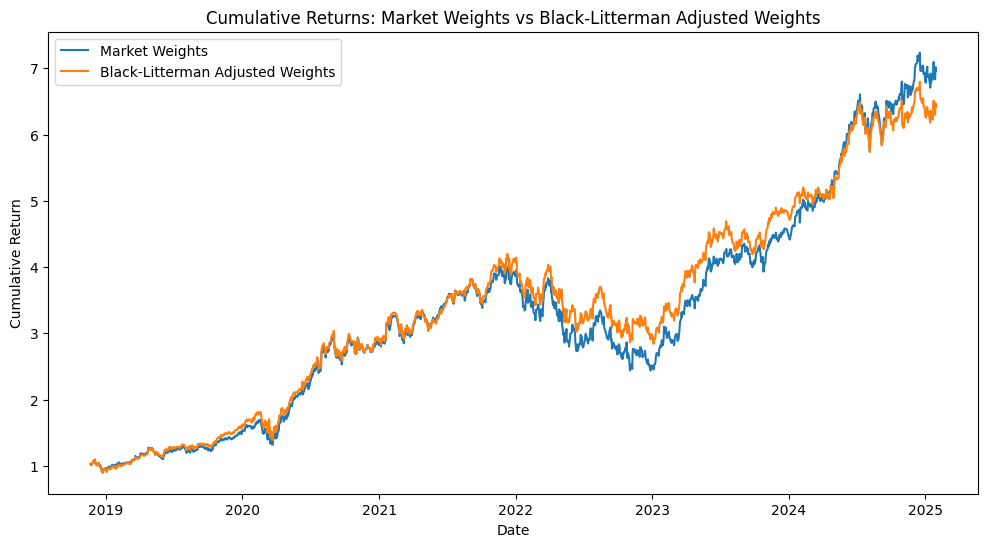

In [11]:
market_cumulative_returns = (prices.pct_change().dot(pd.Series(market_weights)) + 1).cumprod()
bl_cumulative_returns = (prices.pct_change().dot(bl_weights['weight']) + 1).cumprod()


plt.figure(figsize=(12, 6))
plt.plot(market_cumulative_returns, label='Market Weights')
plt.plot(bl_cumulative_returns, label='Black-Litterman Adjusted Weights')
plt.title('Cumulative Returns: Market Weights vs Black-Litterman Adjusted Weights')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

Conclusion:

The Black-Litterman model represents a significant advancement in portfolio optimization theory. By combining market equilibrium with investor views in a mathematically rigorous framework, it provides a practical tool for portfolio managers. The model’s ability to handle uncertainty and incorporate varying levels of confidence in different views makes it particularly valuable in real-world applications.

While the mathematical complexity might seem daunting, the fundamental principle is straightforward: start with market equilibrium and adjust based on your views, while considering the uncertainty in those views. This approach leads to more robust and intuitive portfolio allocations, making it a valuable tool for modern portfolio management.